Author: Quang Vu Nguyen <br/>
Date created: May 2023 <br/>
Email: vunguyen.career@gmail.com <br/>

# Step 0: Environment Setup and Import library

## Environment Setup

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Create new folder for project on Drive

In [ ]:
import os

# Define the path to the new directory
new_dir_path = "/content/drive/MyDrive/project"

# Create the directory if it does not exist
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

### Setting file paths for jupyter notebook and dataset (dataset folder should be available in the 'data-path' directory before running any further code)

In [ ]:
path = '/content/drive/MyDrive/project' # Path for code and project data
data_path = '/content/drive/MyDrive/project/project-data' # Path of project data

### Installation packages

In [ ]:
!pip install transformers
!pip install rank-bm25
!pip install tabulate
!pip install -U imbalanced-learn
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 16.6 MB/s eta 0:00:00


## Import libraries

In [ ]:
# Basic Libraries
import json
import re
import pickle
import collections
import random
import heapq

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary resources from nltk
nltk.download('stopwords')
nltk.download('punkt')

# Data Handling Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt

# Machine Learning, Similarity Measurement, and Imbalanced Learn Libraries
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report  # for generating a classification report
from imblearn.over_sampling import SMOTE  # Import SMOTE

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Transformers Libraries
from transformers import DistilBertTokenizer, DistilBertModel, set_seed
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers import AdamW, get_linear_schedule_with_warmup

# Miscellaneous Libraries
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from tabulate import tabulate
from collections import defaultdict

# Specific Libraries
from rank_bm25 import BM25Okapi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Set seeds for controlling randomness

In [ ]:
# Set the seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
set_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_num_threads(1)

# Step 1: Preprocessing and Data exploring

### Load dataset

In [ ]:
# Load the evidence data from the evidence.json file
with open(data_path + '/evidence.json') as f:
    evidence_data = json.load(f)

# Load the training claims data from the train-claims.json file
with open(data_path + '/train-claims.json') as f:
    train_claims_data = json.load(f)

# Load the development claims data from the dev-claims.json file
with open(data_path + '/dev-claims.json') as f:
    dev_claims_data = json.load(f)

# Load the test data from the test-claims-unlabelled.json file
with open(data_path + '/test-claims-unlabelled.json') as f:
    test_data = json.load(f)


## Data Exploration

### Number of claims

In [ ]:
# Dataset size table
dataset_sizes = {
    'Dataset': ['Train', 'Dev', 'Test'],
    'Number of Claims': [len(train_claims_data), len(dev_claims_data), len(test_data)]
}
dataset_sizes_table = pd.DataFrame(dataset_sizes)
display(dataset_sizes_table)

,Dataset,Number of Claims
0,Train,1228
1,Dev,154
2,Test,153


### Label Distribution

In [ ]:
# 2. Distribution of claim labels in train and dev datasets
train_labels = [v['claim_label'] for v in train_claims_data.values()]
dev_labels = [v['claim_label'] for v in dev_claims_data.values()]

train_label_counts = collections.Counter(train_labels)
dev_label_counts = collections.Counter(dev_labels)

# Label distribution table
label_distribution = {
    'Label': list(train_label_counts.keys()),
    'Train': list(train_label_counts.values()),
    'Dev': list(dev_label_counts.values())
}
label_distribution_table = pd.DataFrame(label_distribution)
display(label_distribution_table)

,Label,Train,Dev
0,DISPUTED,124,68
1,REFUTES,199,41
2,SUPPORTS,519,27
3,NOT_ENOUGH_INFO,386,18


### Top 10 frequent words

In [ ]:
# 3. Most frequent words in claim texts

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

train_claim_texts = ' '.join([v['claim_text'] for v in train_claims_data.values()])
dev_claim_texts = ' '.join([v['claim_text'] for v in dev_claims_data.values()])

train_claim_words = [word for word in train_claim_texts.split() if word not in stop_words]
dev_claim_words = [word for word in dev_claim_texts.split() if word not in stop_words]

train_claim_word_counts = collections.Counter(train_claim_words)
dev_claim_word_counts = collections.Counter(dev_claim_words)

# 4. Most frequent words in evidence texts
evidence_texts = ' '.join(evidence_data.values())
evidence_words = [word for word in evidence_texts.split() if word not in stop_words]
evidence_word_counts = collections.Counter(evidence_words)

# Most frequent words table
top_words_train = train_claim_word_counts.most_common(10)
top_words_dev = dev_claim_word_counts.most_common(10)
top_words_evidence = evidence_word_counts.most_common(10)

top_words = {
    'Train Claim Words': [word for word, _ in top_words_train],
    'Train Claim Counts': [count for _, count in top_words_train],
    'Dev Claim Words': [word for word, _ in top_words_dev],
    'Dev Claim Counts': [count for _, count in top_words_dev],
    'Evidence Words': [word for word, _ in top_words_evidence],
    'Evidence Counts': [count for _, count in top_words_evidence]
}
top_words_table = pd.DataFrame(top_words)
display(top_words_table)

,Train Claim Words,Train Claim Counts,Dev Claim Words,Dev Claim Counts,Evidence Words,Evidence Counts
0,global,223,The,29,The,260715
1,warming,204,warming,29,'s,109814
2,climate,189,global,28,It,83944
3,The,179,climate,23,He,75538
4,CO2,133,carbon,16,--,71391
5,ice,104,CO2,15,In,63247
6,temperature,95,ice,14,also,61866
7,sea,91,dioxide,13,first,45579
8,carbon,85,years,11,:,41809
9,temperatures,82,IPCC,11,one,39166


### Average length of text claims

In [ ]:
# 5. Average length of claim texts
train_claim_lengths = [len(v['claim_text'].split()) for v in train_claims_data.values()]
dev_claim_lengths = [len(v['claim_text'].split()) for v in dev_claims_data.values()]

# 6. Average length of evidence texts
evidence_lengths = [len(text.split()) for text in evidence_data.values()]

# Average text lengths table
average_text_lengths = {
    'Category': ['Train Claims', 'Dev Claims', 'Evidence'],
    'Average Text Length': [np.mean(train_claim_lengths), np.mean(dev_claim_lengths), np.mean(evidence_lengths)]
}
average_text_lengths_table = pd.DataFrame(average_text_lengths)
display(average_text_lengths_table)

,Category,Average Text Length
0,Train Claims,20.097720
1,Dev Claims,21.084416
2,Evidence,19.691925


### Average number of evidence passages

In [ ]:
# 7. Number of evidence passages associated with each claim in train and dev datasets
train_evidence_counts = [len(v['evidences']) for v in train_claims_data.values()]
dev_evidence_counts = [len(v['evidences']) for v in dev_claims_data.values()]

# Average evidence passages table
average_evidence_passages = {
    'Category': ['Train', 'Dev'],
    'Average Number of Evidence Passages': [np.mean(train_evidence_counts), np.mean(dev_evidence_counts)]
}
average_evidence_passages_table = pd.DataFrame(average_evidence_passages)
display(average_evidence_passages_table)

,Category,Average Number of Evidence Passages
0,Train,3.356678
1,Dev,3.188312


## Preprocessed data

### Define preprocess data process

In [ ]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Replace non-alphanumeric characters with spaces
    text = re.sub(r'\W', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Return the preprocessed text
    return text

# Define a function to preprocess data using multiple threads for parallel processing
def preprocess_data(data, func):
    # Use a ThreadPoolExecutor to run the preprocessing function on each value in the data dictionary
    with ThreadPoolExecutor() as executor:
        # Use tqdm to display a progress bar for the preprocessing task
        processed_values = list(tqdm(executor.map(func, data.values()), total=len(data)))
    # Combine the processed values with the corresponding keys to create a new dictionary
    return dict(zip(data.keys(), processed_values))


### Preprocess train,dev, and evidence data

In [ ]:
# Apply the preprocess_data function to the evidence_data dictionary
evidence_data = preprocess_data(evidence_data, preprocess)

# Preprocess the claim_text values in the train_claims_data dictionary using dictionary comprehension
train_claims_data = {
    k: {**v, 'claim_text': preprocess(v['claim_text'])}  # Use the spread operator to add the preprocessed claim_text to the existing dictionary
    for k, v in tqdm(train_claims_data.items(), desc='Preprocessing training claims data')  # Use tqdm to display a progress bar for the preprocessing task
}

# Preprocess the claim_text values in the dev_claims_data dictionary using dictionary comprehension
dev_claims_data = {
    k: {**v, 'claim_text': preprocess(v['claim_text'])}  # Use the spread operator to add the preprocessed claim_text to the existing dictionary
    for k, v in tqdm(dev_claims_data.items(), desc='Preprocessing development claims data')  # Use tqdm to display a progress bar for the preprocessing task
}


  0%|          | 0/1208827 [00:00<?, ?it/s]

Preprocessing training claims data:   0%|          | 0/1228 [00:00<?, ?it/s]

Preprocessing development claims data:   0%|          | 0/154 [00:00<?, ?it/s]

#### Save point 1

In [ ]:
#Save preprocesed data

with open(path + '/preprocessed_data.pkl', 'wb') as f:
    pickle.dump((evidence_data, train_claims_data, dev_claims_data), f)

#### Load point 1 (preprocessed data for train, dev, and evidence)

In [ ]:
# Load the data

with open(path + '/preprocessed_data.pkl', 'rb') as f:
    evidence_data, train_claims_data, dev_claims_data = pickle.load(f)


# Step 2: Build a evidence retrieval system

## F-score evaluation function

In [ ]:
def evaluate_retrieved_evidence(retrieved_evidence, dev_claims_data):
    f_scores = []

    for claim_id, retrieved in retrieved_evidence.items():
        retrieved_evidence_ids = set([evidence[0] for evidence in retrieved])
        true_evidence_ids = set(dev_claims_data[claim_id]['evidences'])

        tp = len(retrieved_evidence_ids.intersection(true_evidence_ids))
        fp = len(retrieved_evidence_ids.difference(true_evidence_ids))
        fn = len(true_evidence_ids.difference(retrieved_evidence_ids))

        if tp == 0:
            precision = 0
            recall = 0
            f_score = 0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f_score = 2 * precision * recall / (precision + recall)

        f_scores.append(f_score)

    return np.mean(f_scores)

## BM25

### Tokenize the evidence text

In [ ]:
evidence_tokenized = [word_tokenize(text) for text in evidence_data.values()]


### Initialise BM25 model

In [ ]:
bm25_model = BM25Okapi(evidence_tokenized)


### Retrive top_k evidence for dev data

In [ ]:
def retrieve_evidence(claim_id, top_k=3):
    claim_text = dev_claims_data[claim_id]['claim_text']
    tokenized_query = word_tokenize(claim_text)
    scores = bm25_model.get_scores(tokenized_query)
    top_indices = np.argsort(scores)[::-1][:top_k]
    return [(list(evidence_data.keys())[i], scores[i]) for i in top_indices]

# Retrieve evidence passages for each claim in the development set:
dev_retrieved_evidence = {k: retrieve_evidence(k) for k in tqdm(dev_claims_data.keys(), desc="Retrieving evidence")}

Retrieving evidence:   0%|          | 0/154 [00:00<?, ?it/s]

### Evaluate

In [ ]:
f_score_BM25 = evaluate_retrieved_evidence(dev_retrieved_evidence, dev_claims_data)
print("f-score for BM25: \n")
print(f_score_BM25)

f-score for BM25: 

0.11216759431045147


## Dense Retrival Model with DistilBert and Consine similarity

### Load a pre-trained BERT language model and get contextual embeddings

In [ ]:
# from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
# import torch
# from transformers import EarlyStoppingCallback

# Load the pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Create a dataset with input pairs (claim, evidence) and corresponding labels
class ClaimEvidenceDataset(torch.utils.data.Dataset):
    def __init__(self, claims_data, tokenizer):
        self.claims_data = list(claims_data.values())  # convert claims_data to a list of values
        self.tokenizer = tokenizer
        self.label_map = {'SUPPORTS': 1, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 0, 'DISPUTED': 0}

    def __len__(self):
        return len(self.claims_data)

    def __getitem__(self, idx):
      claim_data = self.claims_data[idx]
      claim_text = claim_data['claim_text']
      evidence_text = " ".join(claim_data['evidences'])
      labels = self.label_map[claim_data['claim_label']]

      inputs = self.tokenizer(claim_text, evidence_text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
      input_ids = inputs['input_ids']
      attention_mask = inputs['attention_mask']
      
      return {'input_ids': input_ids.squeeze(), 'attention_mask': attention_mask.squeeze(), 'labels': torch.tensor(labels, dtype=torch.long)}



# Create the dataset
train_dataset = ClaimEvidenceDataset(train_claims_data, tokenizer)

# Create the validation dataset
dev_dataset = ClaimEvidenceDataset(dev_claims_data, tokenizer)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    evaluation_strategy='steps',     # evaluation is done at each logging step
    logging_steps=100,               # number of steps between each logging
    save_strategy='steps',           # checkpoint saving strategy
    save_steps=100,                  # number of steps between each checkpoint save
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    metric_for_best_model='eval_loss',   # use validation loss for determining the best model
    seed=seed,                       # seed for training
)

# Create the Trainer
trainer = Trainer(
    model=model,                       # the instantiated Transformers model to be trained
    args=training_args,                # training arguments, defined above
    train_dataset=train_dataset,       # training dataset
    eval_dataset=dev_dataset,          # evaluation dataset
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]   # early stopping callback
)

# Train the model
trainer.train()

trainer.save_model('fine_tuned_distilbert')
tokenizer.save_pretrained('fine_tuned_distilbert')  # Save the tokenizer



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Step,Training Loss,Validation Loss
100,0.674900,0.611900
200,0.544000,0.511992
300,0.472400,0.453201
400,0.392900,0.574837
500,0.404600,0.684649
600,0.402600,0.386421
700,0.279300,0.567634
800,0.171100,0.802599
900,0.121900,1.051751


('fine_tuned_distilbert/tokenizer_config.json',
 'fine_tuned_distilbert/special_tokens_map.json',
 'fine_tuned_distilbert/vocab.txt',
 'fine_tuned_distilbert/added_tokens.json')

In [ ]:
# Load the fine-tuned model and tokenizer
fine_tuned_model_name = 'fine_tuned_distilbert'
embedding_tokenizer = DistilBertTokenizer.from_pretrained(fine_tuned_model_name)
embedding_model = DistilBertModel.from_pretrained(fine_tuned_model_name)

# Use a GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the embedding_model to the device
embedding_model.to(device)

# Define a custom dataset class for processing text data
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Define a collate function to preprocess text data in batches
def collate_fn(batch):
    return embedding_tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)

def get_embedding(text):
    inputs = embedding_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = embedding_model(**inputs.to(device))
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings


# Define a function to generate embeddings for all text data in a dictionary
def generate_embeddings(data):
    # Create a TextDataset object from the values in the input dictionary
    dataset = TextDataset(list(data.values()))
    # Use a DataLoader to process the dataset in batches using the collate function
    loader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn)
    embeddings = []

    # Iterate through the batches and generate embeddings for each batch
    for batch in tqdm(loader, desc='Generating embeddings'):
        # Use the DistilBERT model to generate embeddings for the batch
        with torch.no_grad():
            outputs = embedding_model(**batch.to(device))
        # Extract the embeddings from the output tensor and convert them to a numpy array
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        # Add the batch embeddings to the list of all embeddings
        embeddings.extend(batch_embeddings)

    # Combine the embeddings with the original keys to create a new dictionary
    return dict(zip(data.keys(), embeddings))


Some weights of the model checkpoint at fine_tuned_distilbert were not used when initializing DistilBertModel: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Embedding train, dev, and evidence data

In [ ]:
# Generate embeddings for the evidence dataset using the generate_embeddings function
evidence_embeddings = generate_embeddings(evidence_data)

# Generate embeddings for the training dataset by extracting claim_text values from the train_claims_data dictionary and using generate_embeddings function
train_claims_embeddings = generate_embeddings({k: v['claim_text'] for k, v in train_claims_data.items()})

# Generate embeddings for the development dataset by extracting claim_text values from the dev_claims_data dictionary and using generate_embeddings function
dev_claims_embeddings = generate_embeddings({k: v['claim_text'] for k, v in dev_claims_data.items()})


Generating embeddings:   0%|          | 0/9444 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

#### Save point 2

In [ ]:
# Save the evidence embeddings to a pickled file
with open(f'{path}/distilbert_evidence_embeddings.pkl', 'wb') as f:
    pickle.dump(evidence_embeddings, f)

# Save the training claims embeddings to a pickled file
with open(f'{path}/distilbert_train_claims_embeddings.pkl', 'wb') as f:
    pickle.dump(train_claims_embeddings, f)

# Save the development claims embeddings to a pickled file
with open(f'{path}/distilbert_dev_claims_embeddings.pkl', 'wb') as f:
    pickle.dump(dev_claims_embeddings, f)


#### Check point 2 (Embedded data)

In [ ]:
# Load the evidence embeddings from the pickled file
with open(f'{path}/distilbert_evidence_embeddings.pkl', 'rb') as f:
    evidence_embeddings = pickle.load(f)

# Load the training claims embeddings from the pickled file
with open(f'{path}/distilbert_train_claims_embeddings.pkl', 'rb') as f:
    train_claims_embeddings = pickle.load(f)

# Load the development claims embeddings from the pickled file
with open(f'{path}/distilbert_dev_claims_embeddings.pkl', 'rb') as f:
    dev_claims_embeddings = pickle.load(f)


### Rank evidence using cosine similarity

In [ ]:
# Define a function to retrieve evidence for a claim based on its embedding
def retrieve_evidence(claim_embedding, top_k=3):
    # Calculate the cosine similarity between the claim embedding and all evidence embeddings
    similarities = cosine_similarity(claim_embedding.reshape(1, -1), list(evidence_embeddings.values()))
    
    # Create a dictionary with evidence keys and similarity values
    similarities_dict = {k: sim for k, sim in zip(evidence_embeddings.keys(), similarities[0])}

    # Return the top k evidence items with the largest cosine similarity to the claim embedding
    return heapq.nlargest(top_k, similarities_dict.items(), key=lambda x: x[1])

In [ ]:
# Retrieve evidence passages for each claim in the development set using retrieve_evidence function
dev_retrieved_evidence = {k: retrieve_evidence(v) for k, v in tqdm(dev_claims_embeddings.items(), desc="Retrieving evidence")}

Retrieving evidence:   0%|          | 0/154 [00:00<?, ?it/s]

### Evaluation

In [ ]:
f_score_dense_retrieval = evaluate_retrieved_evidence(dev_retrieved_evidence, dev_claims_data)
print("f-score for Dense Retrieval model: ")
print(f_score_dense_retrieval)

f-score for Dense Retrieval model: 
0.053540507111935684


## Ensemble evidence retrieval system

### Combined BM25 + Dense Retrival

In [ ]:
def min_max_normalize(array):
    min_value, max_value = np.min(array), np.max(array)
    return (array - min_value) / (max_value - min_value)

def get_cosine_similarity(claim_embedding):
    similarities = cosine_similarity(claim_embedding.reshape(1, -1), list(evidence_embeddings.values()))
    return similarities[0]
    
def retrieve_evidence(claim_text, top_k=5, bm25_weight=0.5, similarity_weight=0.5):
    # Calculate BM25 scores
    tokenized_query = word_tokenize(claim_text)
    bm25_scores = bm25_model.get_scores(tokenized_query)
    
    # Get the claim embedding
    claim_embedding = get_embedding(claim_text)[0]

    # Compute cosine similarity
    cosine_similarities = get_cosine_similarity(claim_embedding)
    
    # Normalize BM25 scores and cosine similarity scores using min-max scaling
    normalized_bm25_scores = min_max_normalize(bm25_scores)
    normalized_cosine_similarities = min_max_normalize(cosine_similarities)
    
    # Combine normalized BM25 scores and normalized cosine similarity scores using a weighted sum
    combined_scores = bm25_weight * normalized_bm25_scores + similarity_weight * normalized_cosine_similarities
    
    # Retrieve the top k evidence passages based on the combined scores
    top_indices = np.argsort(combined_scores)[::-1][:top_k]
    return [(list(evidence_data.keys())[i], combined_scores[i]) for i in top_indices]


### Fine-tune Hyperparameter

#### Fine tune weight combination

In [ ]:
# Define a range of values for bm25_weight and similarity_weight
weight_range = np.arange(0.1, 1.0, 0.1)

# Initialize variables to keep track of the best weights and performance
best_weights = (0, 0)
best_performance = 0

# Create a dictionary to store F-scores for each combination of bm25_weight and similarity_weight
f_scores_dict = {}

# Perform a grid search over the weight range
for bm25_weight in weight_range:
    similarity_weight = 1 - bm25_weight
    
    dev_retrieved_evidence = {}
    for k in tqdm(dev_claims_data.keys(), desc=f"Retrieving evidence (bm25_weight={bm25_weight}, similarity_weight={similarity_weight})"):
        dev_retrieved_evidence[k] = retrieve_evidence(dev_claims_data[k]['claim_text'], bm25_weight=bm25_weight, similarity_weight=similarity_weight)

    performance = evaluate_retrieved_evidence(dev_retrieved_evidence, dev_claims_data)

    # Record the F-score for the current combination of weights
    f_scores_dict[(bm25_weight, similarity_weight)] = performance

    # Update the best weights and performance if the current weights yield better performance
    if performance > best_performance:
        best_weights = (bm25_weight, similarity_weight)
        best_performance = performance

print("Best weights:", best_weights)
print("Best performance (F-score):", best_performance)
print("F-scores for all weight combinations:", f_scores_dict)

Retrieving evidence (bm25_weight=0.1, similarity_weight=0.9):   0%|          | 0/154 [00:00<?, ?it/s]

Retrieving evidence (bm25_weight=0.2, similarity_weight=0.8):   0%|          | 0/154 [00:00<?, ?it/s]

Retrieving evidence (bm25_weight=0.30000000000000004, similarity_weight=0.7):   0%|          | 0/154 [00:00<?,…

Retrieving evidence (bm25_weight=0.4, similarity_weight=0.6):   0%|          | 0/154 [00:00<?, ?it/s]

Retrieving evidence (bm25_weight=0.5, similarity_weight=0.5):   0%|          | 0/154 [00:00<?, ?it/s]

Retrieving evidence (bm25_weight=0.6, similarity_weight=0.4):   0%|          | 0/154 [00:00<?, ?it/s]

Retrieving evidence (bm25_weight=0.7000000000000001, similarity_weight=0.29999999999999993):   0%|          | …

Retrieving evidence (bm25_weight=0.8, similarity_weight=0.19999999999999996):   0%|          | 0/154 [00:00<?,…

Retrieving evidence (bm25_weight=0.9, similarity_weight=0.09999999999999998):   0%|          | 0/154 [00:00<?,…

Best weights: (0.4, 0.6)
Best performance (F-score): 0.12440218511647086
F-scores for all weight combinations: {(0.1, 0.9): 0.11580601937744796, (0.2, 0.8): 0.12199031127602557, (0.30000000000000004, 0.7): 0.12199031127602557, (0.4, 0.6): 0.12440218511647086, (0.5, 0.5): 0.12440218511647086, (0.6, 0.4): 0.12277880849309424, (0.7000000000000001, 0.29999999999999993): 0.11323953823953825, (0.8, 0.19999999999999996): 0.11161616161616163, (0.9, 0.09999999999999998): 0.10660688517831375}


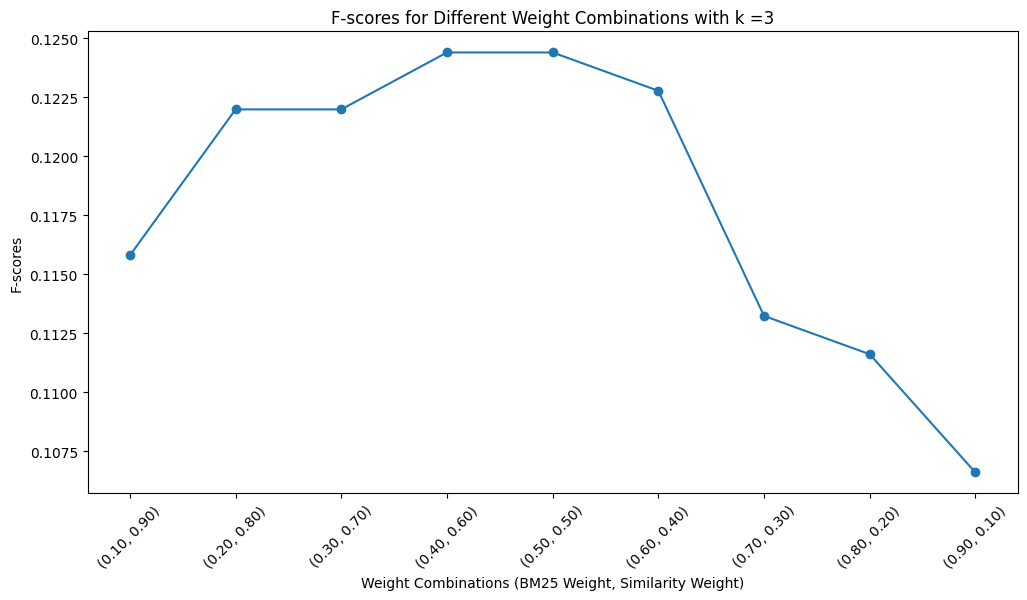

In [ ]:

# Create lists to store the x-axis labels and the F-scores
weight_combinations = []
f_scores = []

# Iterate through the f_scores_dict and extract the weight combinations and F-scores
for (bm25_weight, similarity_weight), f_score in f_scores_dict.items():
    weight_combinations.append(f'({bm25_weight:.2f}, {similarity_weight:.2f})')
    f_scores.append(f_score)

# Create a line plot using the Matplotlib library
plt.figure(figsize=(12, 6))
plt.plot(weight_combinations, f_scores, marker='o')

# Set the axis labels
plt.xlabel('Weight Combinations (BM25 Weight, Similarity Weight)')
plt.ylabel('F-scores')

# Set the title of the plot
plt.title('F-scores for Different Weight Combinations with k =3')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
# Save the results of fine-tune process
# Save the evidence embeddings to a pickled file
with open(f'{path}/fine_tuning_results.pkl', 'wb') as f:
    pickle.dump(f_scores_dict, f)

In [ ]:
# Load the evidence embeddings from the pickled file
with open(f'{path}/fine_tuning_results.pkl', 'rb') as f:
    f_scores_dict = pickle.load(f)

#### Fine tune k

In [ ]:
# Extract the best weight for each model after fine-tuned 
best_bm25_weight, best_similarity_weight = best_weights

# Define a range of values for top_k
top_k_range = range(3, 11, 2)

# Initialize variables to keep track of the best top_k and performance
best_top_k = 0
best_top_k_performance = 0

# Create a dictionary to store F-scores for each top_k value
f_scores_top_k_dict = {}

# Perform a grid search over the top_k range
for top_k in top_k_range:
    dev_retrieved_evidence = {}
    for k in tqdm(dev_claims_data.keys(), desc=f"Retrieving evidence (top_k={top_k})"):
        dev_retrieved_evidence[k] = retrieve_evidence(dev_claims_data[k]['claim_text'], top_k=top_k, bm25_weight=best_bm25_weight, similarity_weight=best_similarity_weight)

    performance = evaluate_retrieved_evidence(dev_retrieved_evidence, dev_claims_data)

    # Record the F-score for the current top_k value
    f_scores_top_k_dict[top_k] = performance

    # Update the best top_k and performance if the current top_k value yields better performance
    if performance > best_top_k_performance:
        best_top_k = top_k
        best_top_k_performance = performance

print("Best top_k:", best_top_k)
print("Best performance (F-score) for top_k:", best_top_k_performance)
print("F-scores for all top_k values:", f_scores_top_k_dict)


Retrieving evidence (top_k=3):   0%|          | 0/154 [00:00<?, ?it/s]

Retrieving evidence (top_k=5):   0%|          | 0/154 [00:00<?, ?it/s]

Retrieving evidence (top_k=7):   0%|          | 0/154 [00:00<?, ?it/s]

Retrieving evidence (top_k=9):   0%|          | 0/154 [00:00<?, ?it/s]

Best top_k: 5
Best performance (F-score) for top_k: 0.12440218511647086
F-scores for all top_k values: {3: 0.12159863945578232, 5: 0.12440218511647086, 7: 0.10894332939787485, 9: 0.10130691819003507}


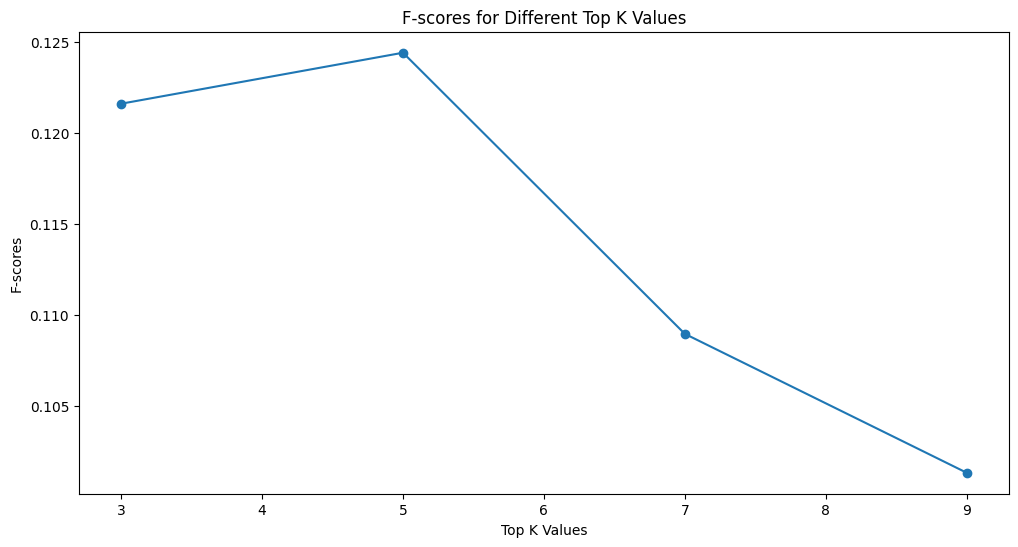

In [ ]:
# Create lists to store the top_k values and the F-scores
top_k_values = []
f_scores_top_k = []

# Iterate through the f_scores_top_k_dict and extract the top_k values and F-scores
for top_k, f_score in f_scores_top_k_dict.items():
    top_k_values.append(top_k)
    f_scores_top_k.append(f_score)

# Create a line plot using the Matplotlib library
plt.figure(figsize=(12, 6))
plt.plot(top_k_values, f_scores_top_k, marker='o')

# Set the axis labels
plt.xlabel('Top K Values')
plt.ylabel('F-scores')

# Set the title of the plot
plt.title('F-scores for Different Top K Values')

# Show the plot
plt.show()


In [ ]:
# Save the fine-tuned k results to a pickled file
with open(f'{path}/fine_tuning_top_k_results.pkl', 'wb') as f:
    pickle.dump(f_scores_top_k_dict, f)

In [ ]:
# Load the fine-tuned k results embeddings from the pickled file
with open(f'{path}/fine_tuning_top_k_results.pkl', 'rb') as f:
    f_scores_top_k_dict = pickle.load(f)

### Evaluation of fined-tuned hybrid evidence retrieval system

In [ ]:
best_bm25_weight, best_similarity_weight = best_weights
### Fined-tuned hybrid evidence retrieval system 
dev_retrieved_evidence = {k: retrieve_evidence(dev_claims_data[k]['claim_text'], top_k=best_top_k, bm25_weight= best_bm25_weight, similarity_weight= best_similarity_weight) for k in tqdm(dev_claims_data.keys(), desc="Retrieving evidence")}


Retrieving evidence:   0%|          | 0/154 [00:00<?, ?it/s]

In [ ]:
 f_score_hybrid = evaluate_retrieved_evidence(dev_retrieved_evidence, dev_claims_data)
 print("f-score for Hybrid model: ")
 print( f_score_hybrid)

f-score for Hybrid model: 
0.12440218511647086


## Retrieval systems performance summary

In [ ]:
# Define the method names and their respective F-scores
methods = ['Hybrid', 'Dense Retrieval', 'BM25']
f_scores = [f_score_hybrid, f_score_dense_retrieval, f_score_BM25]

# Combine the method names and F-scores into a single list of tuples
data = list(zip(methods, f_scores))

# Define the table headers
headers = ['Method', 'F-score']

# Create the table using the tabulate library
table = tabulate(data, headers=headers, tablefmt='grid')

# Print the table
print(table)


+-----------------+-----------+
| Method          |   F-score |
+=================+===========+
| Hybrid          | 0.124402  |
+-----------------+-----------+
| Dense Retrieval | 0.0535405 |
+-----------------+-----------+
| BM25            | 0.112168  |
+-----------------+-----------+


# Step 3: Build classifier

## Traditional machine learning methods

### Feature extraction

In [ ]:
# Extracting semantic features
def extract_features(claims_data, claims_embeddings, evidence_embeddings):
    X = []  # Features for the model
    y = []  # Labels for the model
    label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}

    # Iterate through the claims data
    for claim_id, claim_data in claims_data.items():
        # Get the claim's embedding from the claims_embeddings dictionary
        claim_embedding = claims_embeddings[claim_id]

        # Get the evidence ids associated with the claim
        evidence_ids = claim_data['evidences']

        # Iterate through the evidence_ids
        for evidence_id in evidence_ids:
            # If the evidence_id is not in the evidence_embeddings dictionary, skip it
            if evidence_id not in evidence_embeddings:
                continue

            # Get the evidence's embedding from the evidence_embeddings dictionary
            evidence_embedding = evidence_embeddings[evidence_id]

            # Create the feature vector by horizontally stacking the claim and evidence embeddings
            feature_vector = np.hstack((claim_embedding, evidence_embedding))

            # Add the feature vector to the features list (X)
            X.append(feature_vector)

            # Add the corresponding label to the labels list (y)
            y.append(label_map[claim_data['claim_label']])

    return np.array(X), np.array(y)

train_X, train_y = extract_features(train_claims_data, train_claims_embeddings, evidence_embeddings)
dev_X, dev_y = extract_features(dev_claims_data, dev_claims_embeddings, evidence_embeddings)


### Data preparation

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=seed)
train_X_resampled, train_y_resampled = smote.fit_resample(train_X, train_y)  # Apply SMOTE to the training data

label_encoder = LabelEncoder()
label_encoder.fit(train_y_resampled)

# Encode the resampled labels
train_y_encoded = label_encoder.transform(train_y_resampled)  # Encode the resampled training labels
dev_y_encoded = label_encoder.transform(dev_y)

class FeatureDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.long)

# Update the FeatureDataset instances to use the resampled data
train_dataset = FeatureDataset(train_X_resampled, train_y_encoded)  # Use resampled training data
dev_dataset = FeatureDataset(dev_X, dev_y_encoded)


### Train and evaluation (SVC, RFC, GNB, LR)

In [ ]:
# import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize classifiers
classifiers = {
    "Gaussian Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, verbose=1, solver='lbfgs', n_jobs=-1, random_state=seed),
    "Support Vector Machines": SVC(kernel='rbf', probability=True, random_state=seed),
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=seed),
}

# Dictionary to store the accuracy score of each classifier
accuracy_scores = {}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    classifier.fit(train_X_resampled, train_y_encoded)
    dev_y_pred = classifier.predict(dev_X)
    accuracy = accuracy_score(dev_y_encoded, dev_y_pred)
    accuracy_scores[name] = accuracy  # Store the accuracy score in the dictionary
    print(f"{name} Accuracy: {accuracy:.4f}")



Gaussian Naive Bayes Accuracy: 0.4297


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   38.9s finished


Logistic Regression Accuracy: 0.4094
Support Vector Machines Accuracy: 0.4664
Random Forest Accuracy: 0.4868


## DistilBert-based Sequence Classifier

### Feature Extraction

In [ ]:
def set_random_seeds(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    set_seed(seed_value)

# Set the seeds before initializing the model, tokenizer, and dataloaders
set_random_seeds()

# Extracting semantic features
def extract_features(claims_data, claims_embeddings, evidence_embeddings):
    X = []  # Features for the model
    y = []  # Labels for the model
    label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}

    # Iterate through the claims data
    for claim_id, claim_data in claims_data.items():
        # Get the claim's embedding from the claims_embeddings dictionary
        claim_embedding = claims_embeddings[claim_id]

        # Get the evidence ids associated with the claim
        evidence_ids = claim_data['evidences']

        # Iterate through the evidence_ids
        for evidence_id in evidence_ids:
            # If the evidence_id is not in the evidence_embeddings dictionary, skip it
            if evidence_id not in evidence_embeddings:
                continue

            # Get the evidence's embedding from the evidence_embeddings dictionary
            evidence_embedding = evidence_embeddings[evidence_id]

            # Create the feature vector by horizontally stacking the claim and evidence embeddings
            feature_vector = np.hstack((claim_embedding, evidence_embedding))

            # Add the feature vector to the features list (X)
            X.append(feature_vector)

            # Add the corresponding label to the labels list (y)
            y.append(label_map[claim_data['claim_label']])

    return np.array(X), np.array(y)

train_X, train_y = extract_features(train_claims_data, train_claims_embeddings, evidence_embeddings)
dev_X, dev_y = extract_features(dev_claims_data, dev_claims_embeddings, evidence_embeddings)





### Data preparation

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=seed)
train_X, train_y = smote.fit_resample(train_X, train_y)

# Define a custom dataset class for the claims and evidence data
class ClaimsEvidenceDataset(Dataset):
    def __init__(self, claims_data, tokenizer, max_length=512):
        self.claims_data = claims_data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.claims_data)

    def __getitem__(self, idx):
        # Extract the claim ID, claim text, evidences and label from the claims_data dictionary
        claim_id = list(self.claims_data.keys())[idx]
        claim_data = self.claims_data[claim_id]
        claim = claim_data['claim_text']
        evidence = ' '.join(claim_data['evidences'])
        label = label_map[claim_data['claim_label']]

        # Encode the claim and evidence text using the tokenizer
        encoded_pair = self.tokenizer(claim, evidence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        # Return encoded inputs and label as a tuple
        return encoded_pair, torch.tensor(label, dtype=torch.long)

# Encode the class labels using LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_y)

# Define a label map for the classes
label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}

# Create training and development datasets using ClaimsEvidenceDataset class
train_dataset = ClaimsEvidenceDataset(train_claims_data, embedding_tokenizer)
dev_dataset = ClaimsEvidenceDataset(dev_claims_data, embedding_tokenizer)


In [ ]:
# Define hyperparameters for training
batch_size = 8
num_epochs = 10
max_patience = 3
learning_rate = 2e-5
gradient_accumulation_steps = 4  # Adjust this value depending on your needs

# Calculate class weights for the labels in the training set
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=np.unique(train_y), y=train_y)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define data loaders for training and development sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Set the device for training to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the DistilBERT classification model with pre-trained weights and set the number of output classes
classification_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))
classification_model.to(device)

# Define the optimizer and scheduler
optimizer = AdamW(classification_model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Enable mixed precision training to improve training speed and memory usage
scaler = torch.cuda.amp.GradScaler()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

### Train model

In [ ]:
# Initialize variables for early stopping
best_val_loss = float("inf")
patience = 0
val_loss = 0.0
num_val_batches = 0

# Training loop
classification_model.train()
for epoch in range(num_epochs):
    # Train the model
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for i, (inputs, label) in enumerate(progress_bar):
        inputs = {key: val.reshape(val.shape[0], -1).to(device) for key, val in inputs.items()}
        label = label.to(device)

        # Scale the model forward and backward pass using mixed precision training
        with torch.cuda.amp.autocast():
            outputs = classification_model(**inputs, labels=label)
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(outputs.logits, label) / gradient_accumulation_steps

        scaler.scale(loss).backward()

        # Perform optimizer step and scheduler step only after gradient accumulation steps
        if (i + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            # Update the progress bar with the current loss
            progress_bar.set_postfix({"loss": loss.item()})
            
    # Validation loop to evaluate the model on the development set
    classification_model.eval()
    val_loss = 0.0
    num_val_batches = 0
    for inputs, label in dev_loader:
        inputs = {key: val.reshape(val.shape[0], -1).to(device) for key, val in inputs.items()}
        label = label.to(device)

        # Forward pass through the model without calculating gradients
        with torch.no_grad():
            outputs = classification_model(**inputs, labels=label)
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(outputs.logits, label)
            val_loss += loss.item()
            num_val_batches += 1

    # Calculate the average validation loss
    avg_val_loss = val_loss / num_val_batches
    print(f"Validation loss: {avg_val_loss}")

    # Save the model if the validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(classification_model.state_dict(), "best_model.pt")
        patience = 0
    else:
        patience += 1

    # If the validation loss has not improved for `max_patience` epochs, stop training
    if patience >= max_patience:
        break

# Load the best model for evaluation
classification_model.load_state_dict(torch.load("best_model.pt"))


Epoch 1/10:   0%|          | 0/154 [00:00<?, ?it/s]

Validation loss: 0.9663881048560142


Epoch 2/10:   0%|          | 0/154 [00:00<?, ?it/s]

Validation loss: 0.8638194888830185


Epoch 3/10:   0%|          | 0/154 [00:00<?, ?it/s]

Validation loss: 0.9094380497932434


Epoch 4/10:   0%|          | 0/154 [00:00<?, ?it/s]

Validation loss: 0.9227786481380462


Epoch 5/10:   0%|          | 0/154 [00:00<?, ?it/s]

Validation loss: 1.1782904326915742


<All keys matched successfully>

### Evaluation

In [ ]:
# Evaluation loop to evaluate the model on the development set
classification_model.eval()
all_preds = []  # List to store all predicted labels
all_labels = []  # List to store all true labels

# Disable gradient calculation during evaluation
with torch.no_grad():
    for inputs, label in dev_loader:
        inputs = {key: val.reshape(val.shape[0], -1).to(device) for key, val in inputs.items()}
        label = label.to(device)

        # Forward pass through the model without calculating gradients
        outputs = classification_model(**inputs, labels=label)
        _, preds = torch.max(outputs.logits, dim=1)
        
        # Convert predicted and true labels to numpy arrays and store in the respective lists
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(label.detach().cpu().numpy())

# Convert the class labels to strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Accuracy score
distilbert_accuracy_score = accuracy_score(all_labels, all_preds)

# Print accuracy score
print(f"Accuracy score of DistilBert classifier: {distilbert_accuracy_score}")


Accuracy score of DistilBert classifier: 0.6558441558441559


## Classifiers performance summary

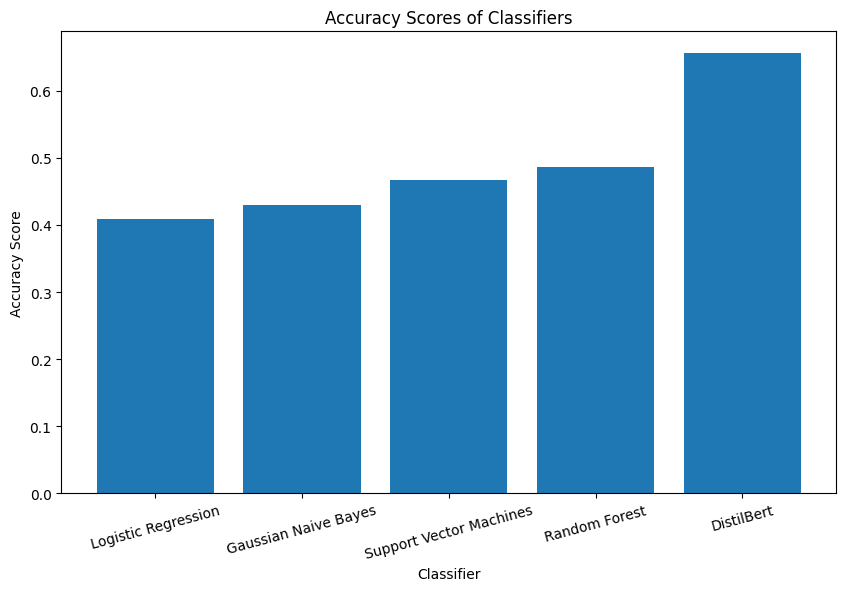

In [ ]:
accuracy_scores["DistilBert"] = distilbert_accuracy_score
# Sort classifiers by accuracy score in ascending order
sorted_accuracy_scores = dict(sorted(accuracy_scores.items(), key=lambda item: item[1]))

# Generate a bar plot of the accuracy scores
plt.figure(figsize=(10, 6))
plt.bar(sorted_accuracy_scores.keys(), sorted_accuracy_scores.values())
plt.xlabel('Classifier')
plt.xticks(rotation=15)
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores of Classifiers')
plt.show()

# Step 4: System integration

## Define function for classify a given claim

In [ ]:
def classify_claim_voting(data, claim_id):
    raw_claim_text = data[claim_id]['claim_text']
    claim_text = preprocess(raw_claim_text)  # Preprocess the claim text on the fly
  
    # Get the claim embedding
    claim_embedding = get_embedding(claim_text)[0]  # Get the first embedding from the embeddings array

    # Retrieve evidence using hybrid retrieval system 
    retrieved_evidence = retrieve_evidence(claim_text, top_k=best_top_k, bm25_weight= best_bm25_weight, similarity_weight= best_similarity_weight)

    # Create claim-evidence pairs
    claim_evidence_pairs = [(claim_text, evidence_data[evidence_id]) for evidence_id, _ in retrieved_evidence]
    # Tokenize and encode the claim-evidence pairs
    encoded_pairs = embedding_tokenizer(claim_evidence_pairs, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move encoded input tensors to the device (GPU if available)
    input_ids = encoded_pairs['input_ids'].to(device)
    attention_mask = encoded_pairs['attention_mask'].to(device)

    # Perform forward pass through the classification model to obtain logits
    with torch.no_grad():
        outputs = classification_model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits.cpu().numpy()

    # Classify each claim-evidence pair separately
    predictions = np.argmax(logits, axis=1)

    # Voting mechanism (majority vote)
    predicted_label_index = np.bincount(predictions).argmax()
    predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]

    # Print individual predictions and the predicted label after voting
    print("Individual Predictions:", predictions)
    print("Predicted Label:", predicted_label)

    return predicted_label, retrieved_evidence


## Evaluate final system on development dataset

### Predict labels for dev dataset

In [ ]:
# Predict claim_label for the dev_data
data = dev_claims_data
dev_predictions = {}
for claim_id, claim_data in tqdm(data.items(), desc="Evaluating test claims"):
    predicted_label, retrieved_evidence = classify_claim_voting(data, claim_id)
    dev_predictions[claim_id] = {
        'claim_label': predicted_label,
        'evidences': [evidence_id for evidence_id, _ in retrieved_evidence]
    }

Evaluating test claims:   0%|          | 0/154 [00:00<?, ?it/s]

Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual

### Decode labels for predictions

In [ ]:
label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}
def decode_label(encoded_label, label_map):
    for label, code in label_map.items():
        if code == encoded_label:
            return label
    raise ValueError(f"Unknown encoded label: {encoded_label}")

# Decoding claim_label in dev_predictions
for claim_id, claim_data in dev_predictions.items():
    decoded_label = decode_label(claim_data['claim_label'], label_map)
    claim_data['claim_label'] = decoded_label

### Save the dev predictions

In [ ]:
# Save dev_predictions to a JSON file
with open(data_path + "/dev-claims-predictions.json", "w") as outfile:
    json.dump(dev_predictions, outfile)

### Evaluate final system on dev dataset using eval.py

In [ ]:
!python /content/drive/MyDrive/project/project-data/eval.py --predictions /content/drive/MyDrive/project/project-data/dev-claims-predictions.json --groundtruth /content/drive/MyDrive/project/project-data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.12440218511647086
Claim Classification Accuracy (A) = 0.44155844155844154
Harmonic Mean of F and A          = 0.19411539388956778


## Predict labels for test data

In [ ]:
# Predict claim_label for the test_data
data = test_data
test_predictions = {}
for claim_id, claim_data in tqdm(data.items(), desc="Evaluating test claims"):
    predicted_label, retrieved_evidence = classify_claim_voting(data, claim_id)
    test_predictions[claim_id] = {
        'claim_label': predicted_label,
        'evidences': [evidence_id for evidence_id, _ in retrieved_evidence]
    }

Evaluating test claims:   0%|          | 0/153 [00:00<?, ?it/s]

Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual Predictions: [0 0 0 0 0]
Predicted Label: 0
Individual

### Decode predictions and save the results

In [ ]:
label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT_ENOUGH_INFO': 2, 'DISPUTED': 3}
def decode_label(encoded_label, label_map):
    for label, code in label_map.items():
        if code == encoded_label:
            return label
    raise ValueError(f"Unknown encoded label: {encoded_label}")

# Decoding claim_label in test_predictions
for claim_id, claim_data in test_predictions.items():
    decoded_label = decode_label(claim_data['claim_label'], label_map)
    claim_data['claim_label'] = decoded_label

In [ ]:
# Save dev_predictions to a JSON file
with open(data_path + "/test-claims-predictions.json", "w") as outfile:
    json.dump(test_predictions, outfile)